# **Lecture ResNet Model**

In this module we will implement the architecture of ResNet. ResNet Model like VGG also has multiple configurations. Each configuration specifies the number of layers and the size of each layer.

This model was introduced in 2015 and is given in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

<br>

The basic idea behind the ResNet network is the `Residual Connection`.

A residual connection is simply a direct connection between the input of a block and the output of a block. Sometimes the residual connection has layers in it, but most of the time it does not. There is an example of an identity residual connection given below:

<img src ="https://drive.google.com/uc?export=view&id=1qhL6RwBzujtOMM-t1oMFfK4T8IxLgsnk" width = 500 >

<br>

The different ResNet configurations are given as:

<img src ="https://drive.google.com/uc?export=view&id=19fMY19sKoiLmdSh2-vnAdRJoKn4fUeFj" width = 500 >

<br>

**We will not implement any of the above deep networrks. We will just show how the residual blocks can be implemented in PyTorch.**

# <Font color = 'pickle'>**ResNet with identity blocks**
<img src ="https://drive.google.com/uc?export=view&id=1OIjA4aLDI8q_ENAuuRQroGa0nli7CXBl" width = 500 >
<br><br>
<img src ="https://drive.google.com/uc?export=view&id=1HGXAcIifqNAkhhIbFkbvaa5CT5xxXoPw" width = 500 >

Picture taklen from : https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L14/2-resnet-example.ipynb

# Setup environment

In [1]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq

    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 29.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [2]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/dog_breed/oct-17'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'data/imagenette2'
kaggle_api_folder = base_folder/'data/.kaggle'

In [3]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_imagenette2 import ImagenetteDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import  plot_losses_acc

In [4]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.9
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


# Adaptive Pooling

In [5]:
import torch.nn as nn
import torch
m = nn.AdaptiveAvgPool2d((5,5))
input = torch.randn(1, 64, 20, 40)
output = m(input)
print(output.shape)

torch.Size([1, 64, 5, 5])


# Global Pooling

In [6]:
m = nn.AdaptiveAvgPool2d((1,1))
input = torch.randn(1, 10, 40, 10)
output = m(input)
print(output.shape)

torch.Size([1, 10, 1, 1])


# Model

In [7]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.main_path(x)
        residual = self.downsample(residual)
        out += residual
        out = nn.ReLU(inplace=True)(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=120):
        super(SimpleResNet, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),  # Output: 16x250x188
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),      # Output: 16x125x94
            ResidualBlock(16, 32, stride=2),                       # Output: 32x63x47
            ResidualBlock(32, 64, stride=2),                       # Output: 64x32x24
            ResidualBlock(64, 128, stride=2),                      # Output: 128x16x12
            ResidualBlock(128, 256, stride=2),                     # Output: 256x8x6
            nn.AdaptiveAvgPool2d((1, 1))                           # Output: 256x1x1
        )

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = SimpleResNet(num_classes=120)
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 1256120
Trainable parameters: 1256120


# Function to load the model

In [9]:
# Function to load the model
def load_model(model_config):
    model = SimpleResNet(model_config['num_classes'])
    return model


# Functions for Transformations

In [10]:
def get_train_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

def get_test_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )


# Function to load DataModule

In [11]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = get_train_transforms(**config['train_transform'])
    test_transform = get_test_transforms(**config['test_transform'])
    dm = ImagenetteDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm



# Function to load LightningModule

In [12]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module


# Function to load the Trainer

In [13]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer



# Function to load components

In [14]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [15]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# Function to Load config files

In [16]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config



# Function to free memory

In [17]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# Run One training and validation batch to check bugs

In [18]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 1.2 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total pa

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.09 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.37, Train_Metric: 0.08


# Find Learning Rate

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.30, Val_Metric: 0.10 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0010000000000000002
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_d278ec54-8a48-4009-ae71-3eb13e96f694.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_d278ec54-8a48-4009-ae71-3eb13e96f694.ckpt


Train_Loss: 2.20, Train_Metric: 0.23
0.0010000000000000002


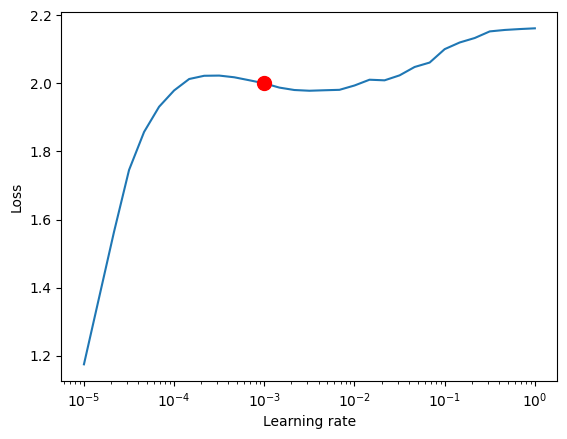

In [19]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=128

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


# Overfit Small Subset

In [20]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
trainer_config['overfit_batches']=1
lightning_module_config['others']['learning_rate']=0.005
trainer_config['max_epochs']=3
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 1.2 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 |

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:262: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.33, Val_Metric: 0.10 | Train_Loss: 2.49, Train_Metric: 0.00


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 2.32, Val_Metric: 0.09 | Train_Loss: 1.12, Train_Metric: 1.00


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 2.77, Val_Metric: 0.10 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Train_Loss: 0.16, Train_Metric: 1.00


# Regularization -I
- Early stopping with a patience of 5, total epochs = 50
- Gradient Clipping
- Weight Deacay of 1
- Reduce Learning rate on plateau
- Use 50% of train/val data

INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the ba

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.10 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.12, Val_Metric: 0.26 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 2.119


Train_Loss: 1.81, Train_Metric: 0.38


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.52, Val_Metric: 0.52 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.599 >= min_delta = 0.0. New best score: 1.521


Train_Loss: 1.42, Train_Metric: 0.52


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.75, Val_Metric: 0.46 | Train_Loss: 1.22, Train_Metric: 0.60
Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.28, Val_Metric: 0.58 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.244 >= min_delta = 0.0. New best score: 1.277


Train_Loss: 1.02, Train_Metric: 0.68


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 1.08, Val_Metric: 0.65 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.197 >= min_delta = 0.0. New best score: 1.079


Train_Loss: 0.92, Train_Metric: 0.70


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 1.04, Val_Metric: 0.65 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.041


Train_Loss: 0.81, Train_Metric: 0.74


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 1.32, Val_Metric: 0.59 | Train_Loss: 0.72, Train_Metric: 0.78
Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 1.10, Val_Metric: 0.64 | Train_Loss: 0.61, Train_Metric: 0.82
Epoch 00008: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.86, Val_Metric: 0.71 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.177 >= min_delta = 0.0. New best score: 0.864


Train_Loss: 0.50, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.92, Val_Metric: 0.70 | Train_Loss: 0.44, Train_Metric: 0.89
Epoch 00010: reducing learning rate of group 0 to 6.2500e-05.


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.79, Val_Metric: 0.75 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 0.787


Train_Loss: 0.39, Train_Metric: 0.91


Validation: 0it [00:00, ?it/s]

Epoch 12: Val_Loss: 0.79, Val_Metric: 0.74 | Train_Loss: 0.36, Train_Metric: 0.92
Epoch 00012: reducing learning rate of group 0 to 3.1250e-05.


Validation: 0it [00:00, ?it/s]

Epoch 13: Val_Loss: 0.77, Val_Metric: 0.75 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.766


Train_Loss: 0.32, Train_Metric: 0.93


Validation: 0it [00:00, ?it/s]

Epoch 14: Val_Loss: 0.77, Val_Metric: 0.75 | Train_Loss: 0.31, Train_Metric: 0.94
Epoch 00014: reducing learning rate of group 0 to 1.5625e-05.


Validation: 0it [00:00, ?it/s]

Epoch 15: Val_Loss: 0.76, Val_Metric: 0.75 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.764


Train_Loss: 0.29, Train_Metric: 0.95


Validation: 0it [00:00, ?it/s]

Epoch 16: Val_Loss: 0.77, Val_Metric: 0.75 | Train_Loss: 0.28, Train_Metric: 0.95
Epoch 00016: reducing learning rate of group 0 to 7.8125e-06.


Validation: 0it [00:00, ?it/s]

Epoch 17: Val_Loss: 0.77, Val_Metric: 0.75 | Train_Loss: 0.28, Train_Metric: 0.95
Epoch 00017: reducing learning rate of group 0 to 3.9063e-06.


Validation: 0it [00:00, ?it/s]

Epoch 18: Val_Loss: 0.76, Val_Metric: 0.75 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.760


Train_Loss: 0.27, Train_Metric: 0.95


Validation: 0it [00:00, ?it/s]

Epoch 19: Val_Loss: 0.76, Val_Metric: 0.75 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.758


Train_Loss: 0.27, Train_Metric: 0.95


Validation: 0it [00:00, ?it/s]

Epoch 20: Val_Loss: 0.76, Val_Metric: 0.76 | Train_Loss: 0.27, Train_Metric: 0.95
Epoch 00020: reducing learning rate of group 0 to 1.9531e-06.


Validation: 0it [00:00, ?it/s]

Epoch 21: Val_Loss: 0.76, Val_Metric: 0.75 | Train_Loss: 0.27, Train_Metric: 0.95
Epoch 00021: reducing learning rate of group 0 to 9.7656e-07.


Validation: 0it [00:00, ?it/s]

Epoch 22: Val_Loss: 0.76, Val_Metric: 0.76 | Train_Loss: 0.26, Train_Metric: 0.96
Epoch 00022: reducing learning rate of group 0 to 4.8828e-07.


Validation: 0it [00:00, ?it/s]

Epoch 23: Val_Loss: 0.76, Val_Metric: 0.75 | Train_Loss: 0.26, Train_Metric: 0.96
Epoch 00023: reducing learning rate of group 0 to 2.4414e-07.


Validation: 0it [00:00, ?it/s]

Epoch 24: Val_Loss: 0.76, Val_Metric: 0.76 | 

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.758. Signaling Trainer to stop.


Train_Loss: 0.26, Train_Metric: 0.96
Epoch 00024: reducing learning rate of group 0 to 1.2207e-07.


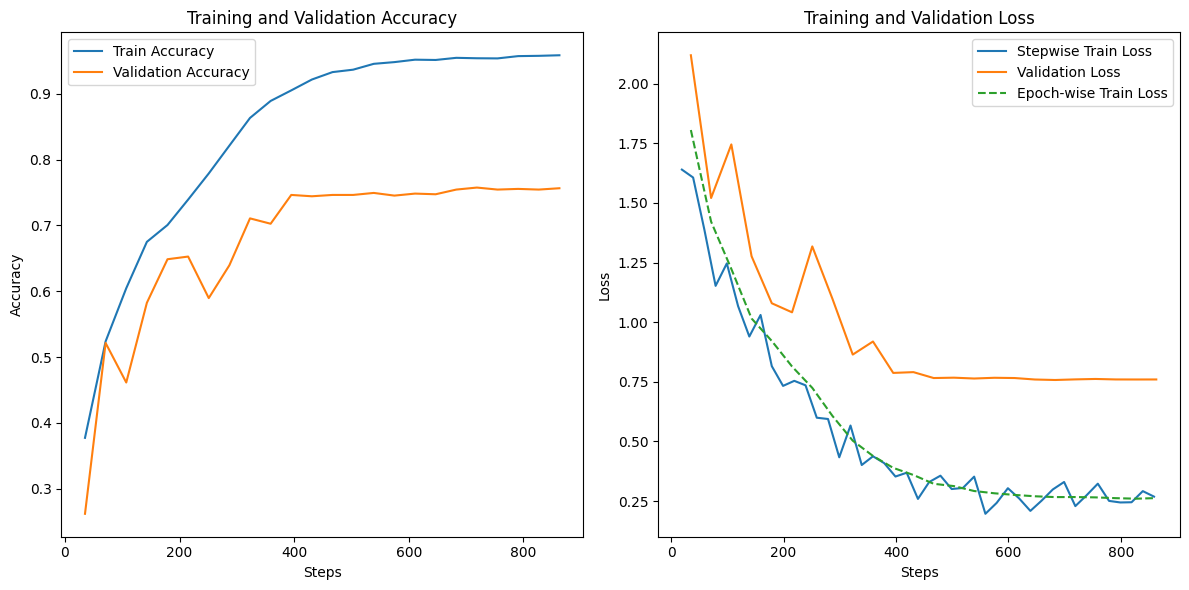

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=18-step=684-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=18-step=684-v1.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 25: Val_Loss: 0.25, Val_Metric: 0.96 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=18-step=684-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=18-step=684-v1.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 25: Val_Loss: 0.76, Val_Metric: 0.75 | Train Accuracy: 96.20
Validation Accuracy: 75.46


epoch,▁▁▁▂▂▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
lr-AdamW,███▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▇▆▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,██▇▇▇▇▆▅▅▅▅▄▃▃▃▃▂▃▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▂▁▂▁▁▁▁
train_metric,▁▂▃▂▃▄▅▅▆▆▇▇▇▇█████████████
trainer/global_step,▁▁▁▂▂▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_loss,█▄▅▄▆▄▅▃▃▃▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂
val_metric,▁▃▃▃▂▄▃▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆█▆
epoch,24
lr-AdamW,0.0
train_loss_epoch,0.26254


In [22]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=50
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.1
lightning_module_config['others']['learning_rate']=0.001
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'min', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass_CNN'
cl_config['wandb']['name']='simple_cnn_exp1'

# Data Module
data_module_config['data_module']['batch_size']=128
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()